# Импорт библиотек

In [28]:
import numpy as np
from matplotlib import pylab as plt
from importlib import reload

from gradient_approximation import *
from optimizers import *
from utils import *
from run_experiments import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Квадратичная задача

### Описание задачи

In [112]:
func_name = "quadratic"
d = 128
L = 1000
mu = 1

SEED = 18
args = init_experiment(func_name, d, seed=SEED, L=L, mu=mu)

np.random.seed(SEED)
x_0 = np.random.random(size=d)
x_0 = x_0 / np.linalg.norm(x_0)

### Поиск точного решения

In [113]:
x_sol = np.linalg.inv(args['A']) @ args['b']

In [114]:
def learning_rate_GD(k):
    return 1./L

  0%|          | 0/3906 [00:00<?, ?it/s]

100%|██████████| 6024/6024 [00:04<00:00, 1400.72it/s]


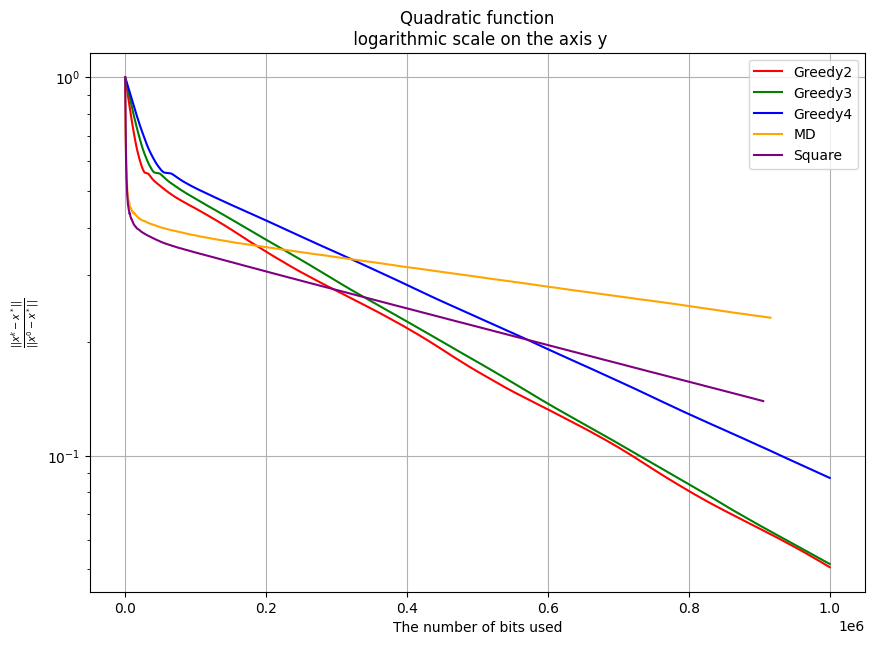

In [115]:
np.random.seed(SEED)

dense_ratio = 1/2

bits_equal = [5, 6]
bits_max = [3, 4]
bits_greedy = [2, 3, 4]
# dtypes = [np.float16, np.float32, np.float64]
# dtypes_names = ["f16", "f32", "f64"]

grad = lambda x: quadratic_grad(x, args['A'], args['b'])
compressors = [GreedyCompressor(grad, k * len(x_0)) for k in bits_greedy]
compressors += [MirrorDescentCompressor(grad, learning_rate_GD(0), len(x_0), 0.1)]
compressors += [SquareGradientCompressor(grad, len(x_0), 0.1)]

approximators = [BitNormGradientApproximator(compressor, func_name, args) for compressor in compressors]

num_calls = 10**6

optimizers_list = [
    GDOptimizer(approximator, learning_rate_GD, x_0, x_sol, max_bits=num_calls) for approximator in approximators
]

for opt in optimizers_list:
    opt.optimize()
make_err_plot(optimizers_list,
            labels=[f"Greedy{bit}" for bit in bits_greedy] + ["MD", "Square"],
            title="Quadratic function")

In [ ]:
def compress(x):
    num_bits = 2 * len(x)
    x = np.copy(x)
    sort_idx = np.argsort(-np.abs(x))

    power = np.maximum(-np.round(np.log2(np.abs(x))), 0)
    bits = np.ceil(np.log2(power + 1))

    sorted_sum_bits = np.cumsum(bits[sort_idx])
    first_zero = np.searchsorted(sorted_sum_bits, num_bits - len(x))

    x[sort_idx[:first_zero]] = (np.sign(x) / (2**power))[sort_idx[:first_zero]]
    x[sort_idx[first_zero:]] = 0
    return x

In [169]:
x = np.array([0, 0.01, 0.1, 10, 1, 4, 0, 0.2])
compress = GreedyCompressor(2 * len(x))
x, compress(x)

(array([ 0.  ,  0.01,  0.1 , 10.  ,  1.  ,  4.  ,  0.  ,  0.2 ]),
 array([0.       , 0.0078125, 0.125    , 1.       , 1.       , 1.       ,
        0.       , 0.25     ]))

## 2. Логистическая регрессия

In [29]:
func_name = "mushrooms"
d = 112
SEED = 18

mu = 0.1
L = 2.5

args = init_experiment(func_name, d, alpha=mu)

np.random.seed(SEED)
x_0 = np.random.random(size=d)
x_0 = x_0 / np.linalg.norm(x_0) * 0.5

In [30]:
def learning_rate_GD(k):
    return 1./L

100%|██████████| 689/689 [00:03<00:00, 195.85it/s]


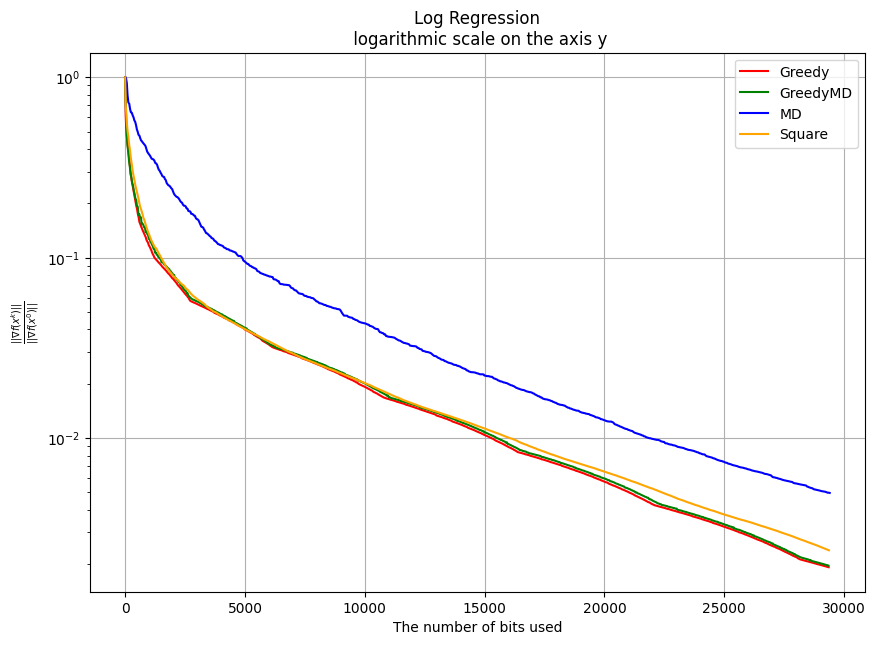

In [ ]:
np.random.seed(SEED)
use_ratio = 0.1


grad = lambda x: logreg_grad(x, args['X'], args['y'], args['alpha'])

compressors = [GreedyCompressor(grad, len(x_0), use_ratio)]
compressors += [MirrorDescentGreedyCompressor(grad, learning_rate_GD(0), len(x_0), use_ratio)]
compressors += [MirrorDescentCompressor(grad, learning_rate_GD(0), len(x_0), use_ratio)]
compressors += [SquareGradientCompressor(grad, len(x_0), use_ratio)]

approximators = [BitNormGradientApproximator(compressor, func_name, args) for compressor in compressors]

num_calls = 10**5

optimizers_list = [
    GDOptimizer(approximator, learning_rate_GD, x_0, max_bits=num_calls) for approximator in approximators
]

for opt in optimizers_list:
    opt.optimize()
make_err_plot(optimizers_list, labels=[f"Greedy", "GreedyMD", "MD", "Square"], title="Log Regression")

100%|██████████| 558/558 [00:02<00:00, 205.71it/s]


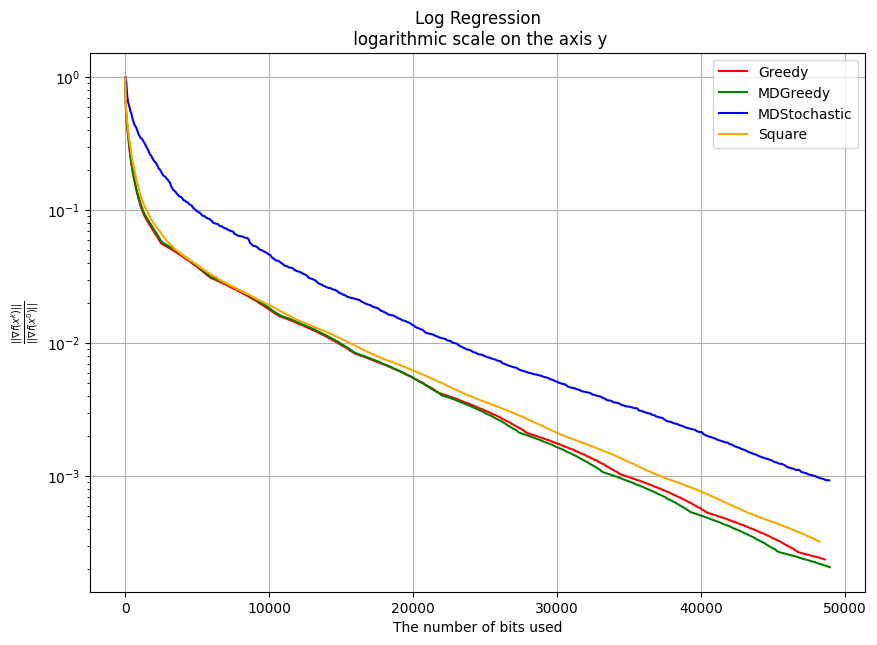

In [24]:
np.random.seed(SEED)
use_ratio = 0.2

grad = lambda x: logreg_grad(x, args['X'], args['y'], args['alpha'])

compressors = [GreedyCompressor(grad, len(x_0), use_ratio)]
compressors += [MirrorDescentGreedyCompressor(grad, learning_rate_GD(0), len(x_0), use_ratio)]
compressors += [MirrorDescentCompressor(grad, learning_rate_GD(0), len(x_0), use_ratio)]
compressors += [SquareGradientCompressor(grad, len(x_0), use_ratio)]

approximators = [BitNormGradientApproximator(compressor, func_name, args) for compressor in compressors]

num_calls = 10**5

optimizers_list = [
    GDOptimizer(approximator, learning_rate_GD, x_0, max_bits=num_calls) for approximator in approximators
]

for opt in optimizers_list:
    opt.optimize()
make_err_plot(optimizers_list, labels=[f"Greedy", "MDGreedy", "MDStochastic", "Square"], title="Log Regression")

 67%|██████▋   | 1126/1675 [00:10<00:05, 105.75it/s]


Precision 1e-06 achieved at step 1126!


 65%|██████▍   | 1088/1675 [03:34<01:55,  5.08it/s]


Precision 1e-06 achieved at step 1088!


 64%|██████▎   | 1067/1675 [03:34<02:02,  4.98it/s]


Precision 1e-06 achieved at step 1067!


 66%|██████▌   | 1099/1675 [03:40<01:55,  4.98it/s]

Precision 1e-06 achieved at step 1099!


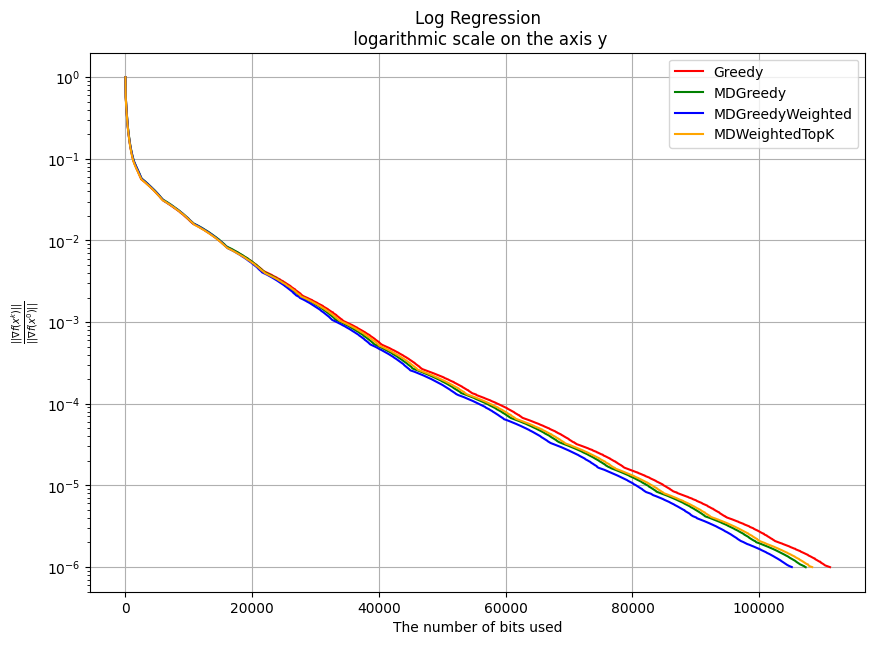

In [36]:
np.random.seed(SEED)
use_ratio = 0.2

grad = lambda x: logreg_grad(x, args['X'], args['y'], args['alpha'])

compressors = [GreedyCompressor(grad, len(x_0), use_ratio)]
compressors += [MirrorDescentGreedyCompressor(grad, learning_rate_GD(0), len(x_0), use_ratio)]
compressors += [MirrorDescentGreedyWeightedCompressor(grad, learning_rate_GD(0), len(x_0), use_ratio)]
compressors += [MirrorDescentWeightedTopkCompressor(grad, learning_rate_GD(0), len(x_0), use_ratio)]

approximators = [BitNormGradientApproximator(compressor, func_name, args) for compressor in compressors]

num_calls = 3 * 10**5

optimizers_list = [
    GDOptimizer(approximator, learning_rate_GD, x_0, max_bits=num_calls) for approximator in approximators
]

for opt in optimizers_list:
    opt.optimize()
make_err_plot(optimizers_list, labels=[f"Greedy", "MDGreedy", "MDGreedyWeighted", "MDWeightedTopK"], title="Log Regression")

Добавить выбор шага

Стартовать из нормы градиента, посмотреть откорректирует ли MD

 67%|██████▋   | 1126/1675 [00:09<00:04, 122.45it/s]


Precision 1e-06 achieved at step 1126!


 65%|██████▍   | 1088/1675 [03:06<01:40,  5.82it/s]


Precision 1e-06 achieved at step 1088!


 85%|████████▌ | 1430/1675 [04:48<00:49,  4.96it/s]


Precision 1e-06 achieved at step 1430!


 72%|███████▏  | 1203/1675 [00:07<00:03, 156.18it/s]


Precision 1e-06 achieved at step 1203!


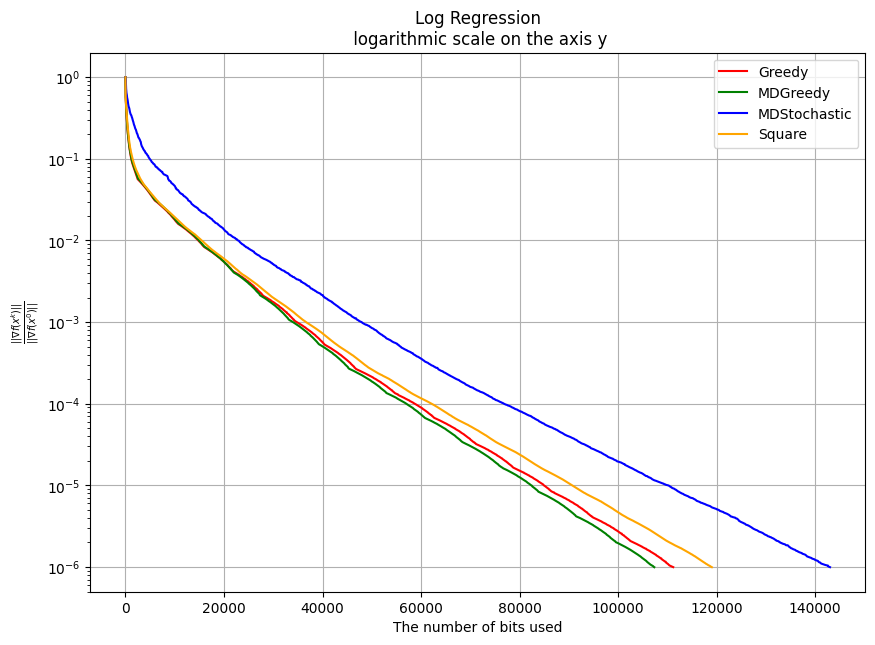

In [ ]:
np.random.seed(SEED)
use_ratio = 0.2

grad = lambda x: logreg_grad(x, args['X'], args['y'], args['alpha'])

compressors = [GreedyCompressor(grad, len(x_0), use_ratio)]
compressors += [MirrorDescentGreedyCompressor(grad, learning_rate_GD(0), len(x_0), use_ratio)]
compressors += [MirrorDescentCompressor(grad, learning_rate_GD(0), len(x_0), use_ratio)]
compressors += [SquareGradientCompressor(grad, len(x_0), use_ratio)]

approximators = [BitNormGradientApproximator(compressor, func_name, args) for compressor in compressors]

num_calls =  3 * 10**5

optimizers_list = [
    GDOptimizer(approximator, learning_rate_GD, x_0, max_bits=num_calls) for approximator in approximators
]

for opt in optimizers_list:
    opt.optimize()
make_err_plot(optimizers_list, labels=[f"Greedy", "MDGreedy", "MDStochastic", "SquareStochastic"], title="Log Regression")

100%|██████████| 357/357 [00:02<00:00, 172.86it/s]


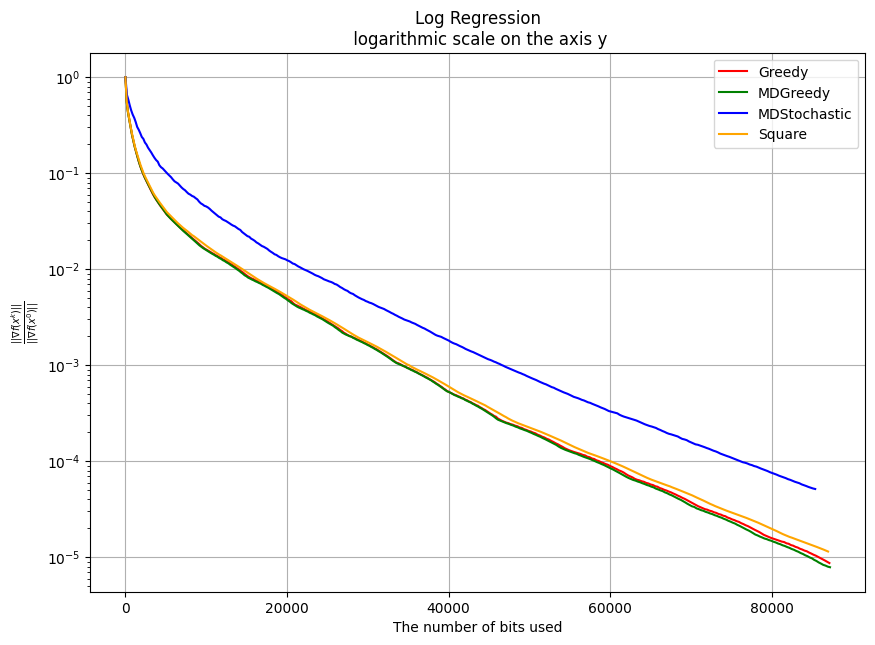

In [25]:
np.random.seed(SEED)
use_ratio = 0.5

grad = lambda x: logreg_grad(x, args['X'], args['y'], args['alpha'])

compressors = [GreedyCompressor(grad, len(x_0), use_ratio)]
compressors += [MirrorDescentGreedyCompressor(grad, learning_rate_GD(0), len(x_0), use_ratio)]
compressors += [MirrorDescentCompressor(grad, learning_rate_GD(0), len(x_0), use_ratio)]
compressors += [SquareGradientCompressor(grad, len(x_0), use_ratio)]

approximators = [BitNormGradientApproximator(compressor, func_name, args) for compressor in compressors]

num_calls = 10**5

optimizers_list = [
    GDOptimizer(approximator, learning_rate_GD, x_0, max_bits=num_calls) for approximator in approximators
]

for opt in optimizers_list:
    opt.optimize()
make_err_plot(optimizers_list, labels=[f"Greedy", "MDGreedy", "MDStochastic", "Square"], title="Log Regression")

In [6]:
# adding noise components

args['X'] = np.hstack((args['X'], np.random.rand(*args['X'].shape)))
d = 224

np.random.seed(SEED)
x_0 = np.random.random(size=d)
x_0 = x_0 / np.linalg.norm(x_0) * 0.5


100%|██████████| 279/279 [00:04<00:00, 65.91it/s]


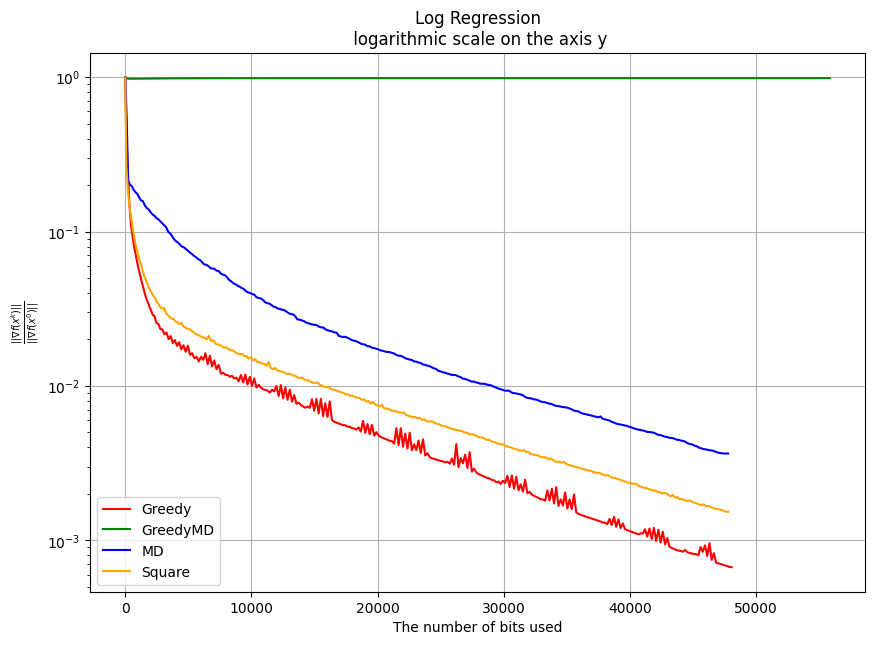

In [7]:
np.random.seed(SEED)

use_ratio = 0.2

grad = lambda x: logreg_grad(x, args['X'], args['y'], args['alpha'])

compressors = [GreedyCompressor(grad, len(x_0), use_ratio)]
compressors += [MirrorDescentGreedyCompressor(grad, learning_rate_GD(0), len(x_0), use_ratio)]
compressors += [MirrorDescentCompressor(grad, learning_rate_GD(0), len(x_0), use_ratio)]
compressors += [SquareGradientCompressor(grad, len(x_0), use_ratio)]

approximators = [BitNormGradientApproximator(compressor, func_name, args) for compressor in compressors]

num_calls = 10**5

optimizers_list = [
    GDOptimizer(approximator, learning_rate_GD, x_0, max_bits=num_calls) for approximator in approximators
]

for opt in optimizers_list:
    opt.optimize()
make_err_plot(optimizers_list, labels=[f"Greedy", "GreedyMD", "MD", "Square"], title="Log Regression")